# DeepChords

Multiheaded Root and Chord recognition model.

In [14]:
%matplotlib inline

# Setup autoreload for local modules, otherwise Jupyter caches modules
# on first load. Add new local modules here if necessary.
%load_ext autoreload
%autoreload 2
%aimport deepsamples, helpers, gen_chord_samples, gen_note_samples

# To use specific version
# %pip install --user tensorflow==2.1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Samples (Option 1)

Download dependencies and generate samples here. Alternatively you can download the pre-generated samples from the next step.

In [ ]:
# Onetime Setup
!rm -rf samples
%pip install midiutil
!sudo apt-get -y install sox fluidsynth
!wget --no-check-certificate https://muthanna.com/deepears/soundfont.sf2

In [ ]:
!mkdir -p samples
from gen_chord_samples import gen_chord_samples

In [15]:
!find samples | wc -l
!sox --i samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav

2296

Input File     : 'samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:00.33 = 5280 samples ~ 24.75 CDDA sectors
File Size      : 10.6k
Bit Rate       : 257k
Sample Encoding: 16-bit Signed Integer PCM



# Download Samples (Option 2)

In [ ]:
!wget --no-check-certificate https://muthanna.com/deepears/chord-samples-v2.zip
!rm -rf samples
!unzip -q chord-samples-v2.zip
!ls -l samples/ | wc -l
!ls -l samples | head

# Config and Setup

In [2]:
import os
files = os.listdir("samples")
len(files)

10800

In [3]:
%matplotlib inline

import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt

import helpers
from helpers import Config

Spectrogram for samples/D4-P51-major-i1-293.665-S0-V0.43-noreject-sustain.wav
(257, 67)


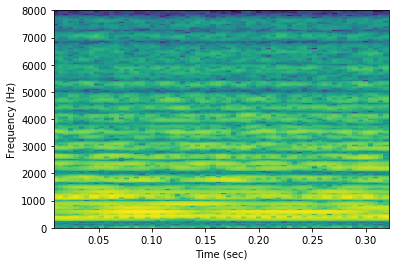

In [32]:
import os

config = Config(
    rows=256,
    cols = 64,
    s_nperseg = 256,
    s_nfft = 512,
    s_noverlap = 180,
    log_scale = True,
    resample = 16000)

helpers.spectrogram_from_file("samples/"+files[0], config=config)
None

# DeepEars Code

In [10]:
import re
import sys
import os

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from deepsamples import ChordSamples

### DeepChords1D

In [15]:
class DeepChords1D:
  def __init__(self, deep_samples):
    self.samples = deep_samples
    self.s_rows = deep_samples.get_config().rows
    self.s_cols = deep_samples.get_config().cols

    self.model = tf.keras.models.Sequential([
        # TimeDistributed expects first dim to be temporal, so we permute (swap dims 2 and 1), since cols are time, not rows
        layers.Permute((2, 1), input_shape=(self.s_rows, self.s_cols)),
        layers.Reshape((1, self.s_cols, self.s_rows)),

        # 200 feature maps, 16 stride length
        layers.TimeDistributed(layers.Conv1D(200, 16, activation='relu')),
        layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),

        layers.TimeDistributed(layers.Conv1D(100, 16, activation='relu')),
        layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),

        layers.Reshape((70, 100)),
        tf.keras.layers.LSTM(100, activation='relu', return_sequences=False),
        
        # tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(100, activation='relu', return_sequences=True),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(self.samples.get_chord_classes()), activation='softmax')])
    

  def train(self, epochs=30):
    self.model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
    ((training_xs, training_ys), (testing_xs, testing_ys)) = self.samples.get_chord_samples()
    return self.model.fit(training_xs, training_ys, epochs=epochs, batch_size=100,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)],
                         validation_data=(testing_xs, testing_ys))
  
  def predict(self, file):
    Sxx = DeepSamples.spectrogram(file).reshape(1, self.s_rows, self.s_cols,1)
    chord_class = self.model.predict_classes(Sxx)
    return self.get_chord_classes()[int(chord_class)]

samples = ChordSamples(num_samples=10)
deepchords = DeepChords1D(samples)
deepchords.model.summary()

Initializing DeepSamples:ChordSamples...
rows/cols: 129 71
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 71, 129)           0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 1, 71, 129)        0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 1, 56, 200)        413000    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 1, 28, 200)        0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 1, 13, 100)        320100    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1, 6, 100)         0         
_____________________________________________________________

### DeepChords2D

In [36]:
class DeepChords2D:
  def __init__(self, deep_samples):
    self.samples = deep_samples
    self.s_rows = deep_samples.get_config().rows
    self.s_cols = deep_samples.get_config().cols

    self.model = tf.keras.models.Sequential([
        # TimeDistributed expects first dim to be temporal, so we permute (swap dims 2 and 1), since cols are time, not rows
        layers.Permute((2, 1), input_shape=(self.s_rows, self.s_cols)),
        layers.Reshape((1, self.s_cols, self.s_rows, 1)),

        # 200 feature maps, 16 stride length
        layers.TimeDistributed(layers.Conv2D(200, (3, 3), activation='relu')),
        layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2,2))),

        layers.TimeDistributed(layers.Conv2D(100, (3, 3), activation='relu')),
        layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))),

        layers.Reshape((80 * 126, 100)),
        tf.keras.layers.LSTM(100, activation='relu', return_sequences=False),
        
        # tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(100, activation='relu', return_sequences=True),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(self.samples.get_chord_classes()), activation='softmax')])
    

  def train(self, epochs=30):
    self.model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
    ((training_xs, training_ys), (testing_xs, testing_ys)) = self.samples.get_chord_samples()
    return self.model.fit(training_xs, training_ys, epochs=epochs, batch_size=100,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)],
                         validation_data=(testing_xs, testing_ys))
  
  def predict(self, file):
    Sxx = DeepSamples.spectrogram(file).reshape(1, self.s_rows, self.s_cols,1)
    chord_class = self.model.predict_classes(Sxx)
    return self.get_chord_classes()[int(chord_class)]

samples = ChordSamples(num_samples=10, config=config)
samples.load_chords()
deepchords = DeepChords2D(samples)
deepchords.model.summary()

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Loading sample files...
Shuffling samples...
Generating spectrograms...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_7 (Permute)          (None, 64, 256)           0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 1, 64, 256, 1)     0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 1, 62, 254, 200)   2000      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 1, 31, 127, 200)   0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 1, 29, 125, 100)   180100    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 1, 14, 62, 100)    


# Train

In [ ]:
# Auth this runtime to GCP (once only)
#
# Do it if you want to save the model immediately
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
config = DefaultConfig
config.rows = 120
config.cols = 66
config.no_spectrogram = True

prod_samples = DeepSamples(num_samples=15000, config=config)
prod_samples.load_notes()

Initializing DeepSamples...
size 120 66
xs (15000, 120, 66)
freq_ys (15000,)
chord_ys (15000, 8)
Loading sample files...
Shuffling samples...
Generating spectrograms...


In [ ]:
deepears = DeepPitches(prod_samples)
history = deepears.train(epochs=50)

Learning on time domain data
Train on 12000 samples, validate on 3000 samples
Epoch 1/50
12000/12000 [==============================] - 7s 569us/sample - loss: 188.1797 - mse: 188.1799 - mae: 2.2875 - val_loss: 0.9889 - val_mse: 0.9889 - val_mae: 0.7956
Epoch 2/50
12000/12000 [==============================] - 6s 494us/sample - loss: 1.0038 - mse: 1.0038 - mae: 0.8026 - val_loss: 0.9890 - val_mse: 0.9890 - val_mae: 0.7971
Epoch 3/50
12000/12000 [==============================] - 6s 497us/sample - loss: 1.0028 - mse: 1.0028 - mae: 0.8016 - val_loss: 0.9890 - val_mse: 0.9890 - val_mae: 0.7969
Epoch 4/50
12000/12000 [==============================] - 6s 495us/sample - loss: 1.0030 - mse: 1.0030 - mae: 0.8038 - val_loss: 0.9889 - val_mse: 0.9889 - val_mae: 0.7943
Epoch 5/50
12000/12000 [==============================] - 6s 495us/sample - loss: 1.0027 - mse: 1.0027 - mae: 0.8005 - val_loss: 0.9889 - val_mse: 0.9889 - val_mae: 0.7957
Epoch 6/50
12000/12000 [==============================] - 

In [ ]:
plot_regression_history(history)

# plot_history(history)

NameError: ignored

In [ ]:
files = os.listdir("samples")
np.random.shuffle(files)

notes = ['A', 'As', 'B', 'C', 'Cs', 'D', 'Ds', 'E', 'F', 'Fs', 'G', 'Gs']
note_map = {}
for i, note_name in enumerate(notes):
  note_map[note_name] = i

reject_map = {
    'reject': 0,
    'noreject': 1
}

count_by_root = np.zeros((12))
errors_by_root = np.zeros((12))
count_by_key = np.zeros((8 * 12))
errors_by_key = np.zeros((8 * 12))
count_by_reject = np.zeros((2))
errors_by_reject = np.zeros((2))

for i, file in enumerate(files[17000:18000]):
  predicted = deepears.predict("samples/"+file).flatten()[0]
  parts = DeepSamples.note_parts(file)

  octave = int(parts['octave'])
  note = parts['root']
  freq = parts['freq']
  reject = parts['reject']
  error = abs(predicted - freq)

  count_by_root[note_map[note]] += 1
  errors_by_root[note_map[note]] += error
  count_by_key[(octave * 12) + note_map[note]] += 1
  errors_by_key[(octave * 12) + note_map[note]] += error
  count_by_reject[reject_map[reject]] += 1
  errors_by_reject[reject_map[reject]] += error

  # print(file, base, predicted, actual, error)

errors_by_key /= count_by_key
errors_by_reject /= count_by_reject
errors_by_root /= count_by_root

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


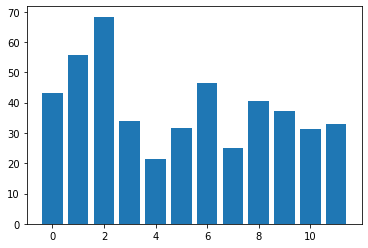

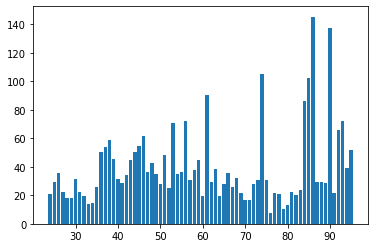

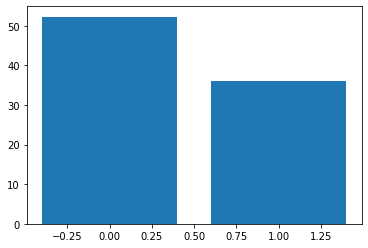

In [ ]:
plt.bar(np.arange(len(errors_by_root)), errors_by_root)
plt.show()
plt.bar(np.arange(len(errors_by_key)), errors_by_key)
plt.show()
plt.bar(np.arange(len(errors_by_reject)), errors_by_reject)
plt.show()

In [ ]:
plt.bar(np.arange(len(errors_by_reject)), errors_by_reject)

In [ ]:
np.mean(np.nan_to_num(errors_by_key[0:80]))

19.244542657486097

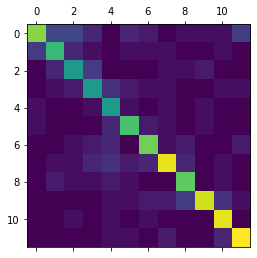

In [ ]:
((training_xs, training_ys), (testing_xs, testing_ys)) = prod_samples.get_root_samples()

predictions = deepears.model.predict_classes(testing_xs)
labels = np.argmax(testing_ys, axis=1)
plt.matshow(tf.math.confusion_matrix(predictions, labels))


In [ ]:
root_l1 = deepears.model.get_layer(index=2)

# weights[0] is NN weights, and weights[1] is bias weights
# [print(weight.shape) for weight in root_l1.get_weights()]

In [ ]:
w = root_l1.get_weights()[0].reshape(64, 3, 3)

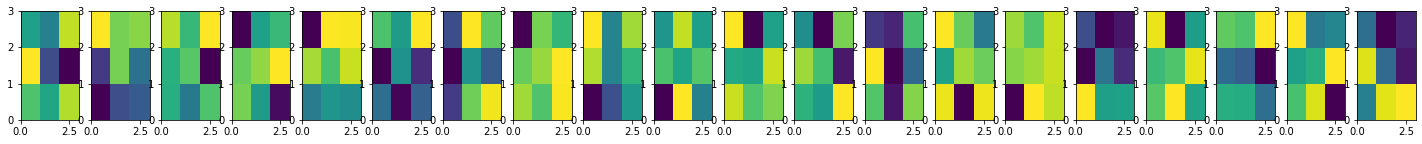

In [ ]:
fig, ax = plt.subplots(1, 20, figsize=(25, 2))
for i in range(0, 20):
  ax[i].pcolormesh(w[i])
plt.show()

(1, 511, 92, 64)


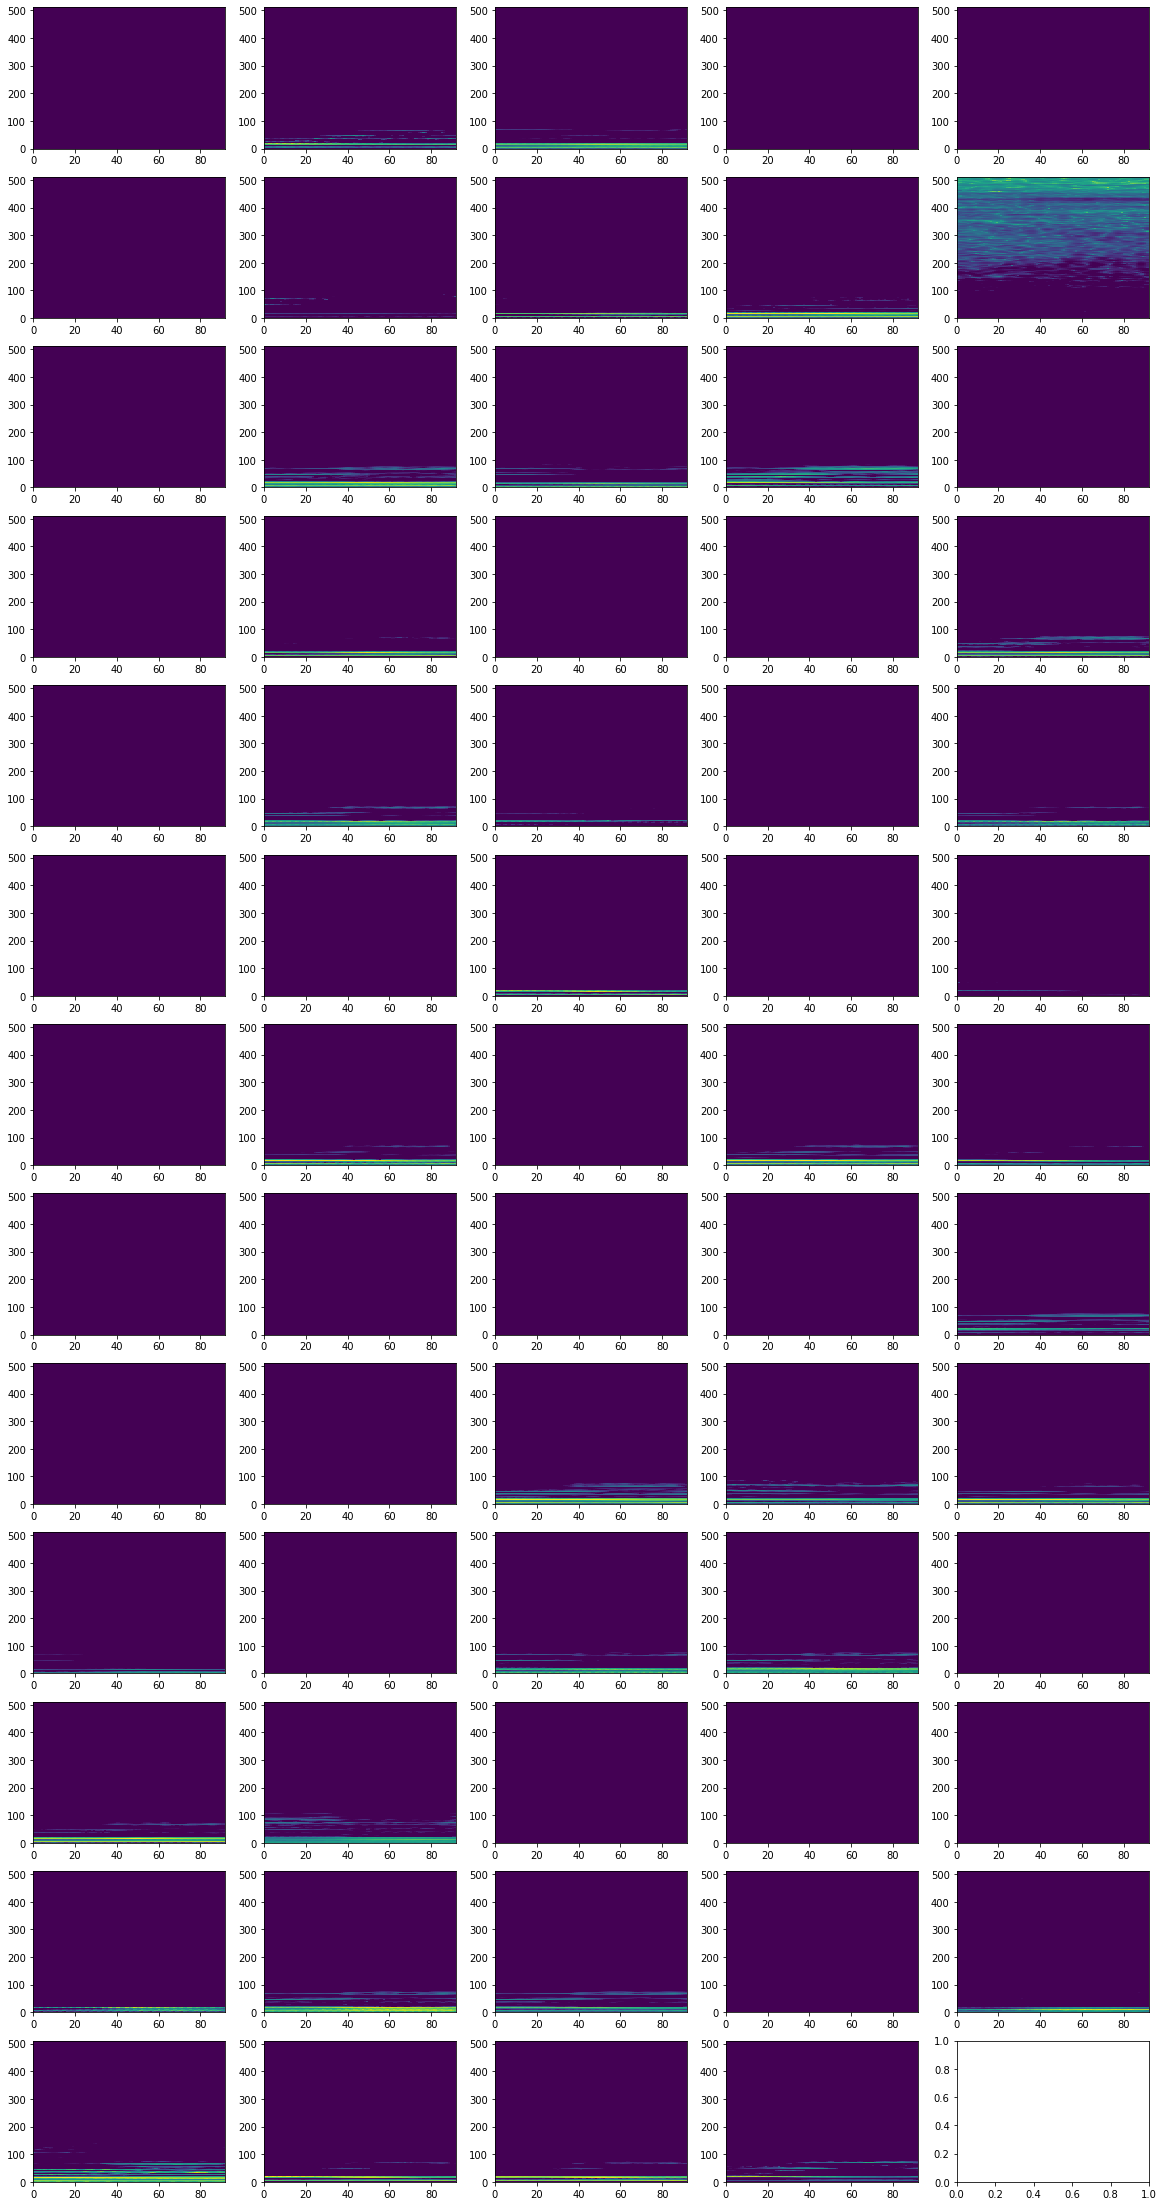

In [ ]:
def visualize_filters(layer_num, count, x, deepears=deepears):
  layer = deepears.model.get_layer(index=layer_num)
  layer_output=layer.output
  
  intermediate_model=tf.keras.models.Model(inputs=deepears.model.input,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x.reshape(1, deepears.s_rows, deepears.s_cols))

  col_size=5
  row_size=int(count / col_size) + 1
  
  print(np.shape(intermediate_prediction))
  fig,ax=plt.subplots(row_size,col_size,figsize=(20,40))

  img_index=0
  row=0
  col=0
  while img_index < count:
    ax[row][col].pcolormesh(intermediate_prediction[0, :, :, img_index])
    img_index=img_index+1
    col += 1
    if col >= col_size:
      col = 0
      row +=1
    if img_index > count: break

visualize_filters(2, 64, x=prod_samples.xs[1200])

reshape_1: 1 (1, 513, 94, 1)
dropout_4: 1 (1, 513, 94, 1)
conv2d_4: 64 (1, 511, 92, 64)
max_pooling2d_4: 64 (1, 255, 46, 64)
conv2d_5: 128 (1, 253, 44, 128)
max_pooling2d_5: 128 (1, 126, 22, 128)
conv2d_6: 128 (1, 124, 20, 128)
max_pooling2d_6: 128 (1, 62, 10, 128)
conv2d_7: 256 (1, 60, 8, 256)
max_pooling2d_7: 256 (1, 30, 4, 256)
flatten_1: 30720 (1, 30720)
dropout_5: 30720 (1, 30720)
dense_3: 512 (1, 512)
dropout_6: 512 (1, 512)
dense_4: 256 (1, 256)
dropout_7: 256 (1, 256)
dense_5: 1 (1, 1)


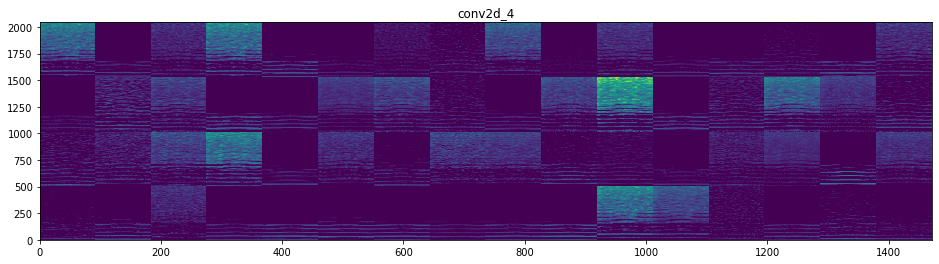

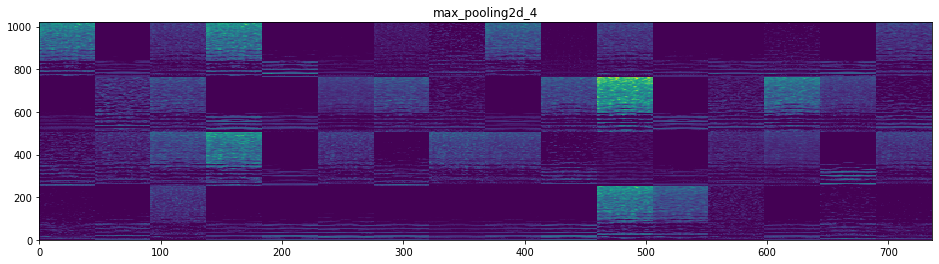

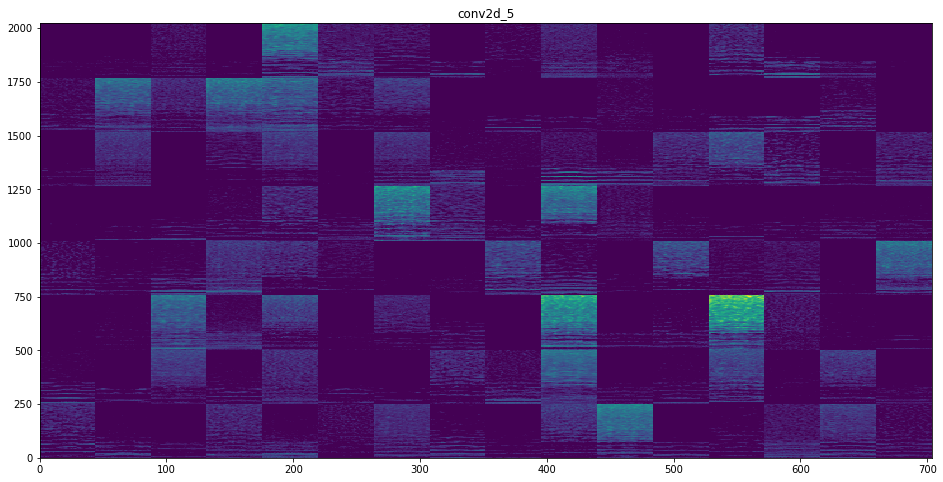

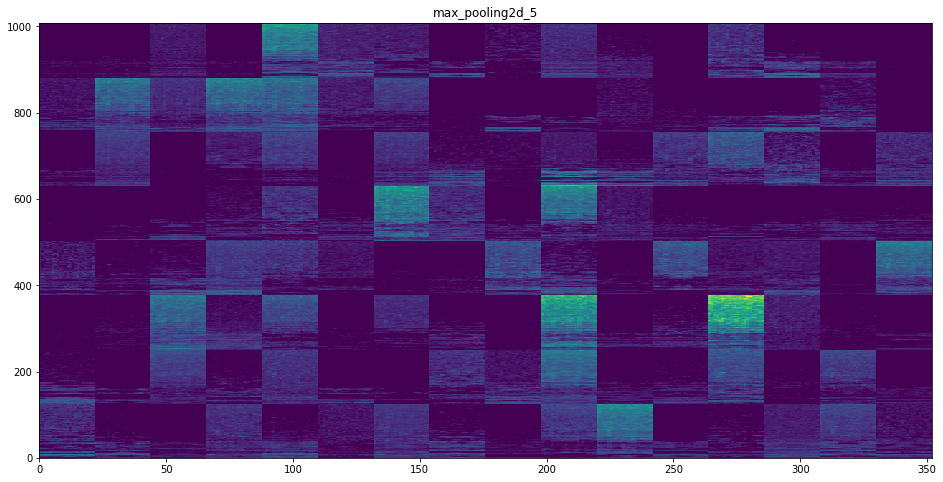

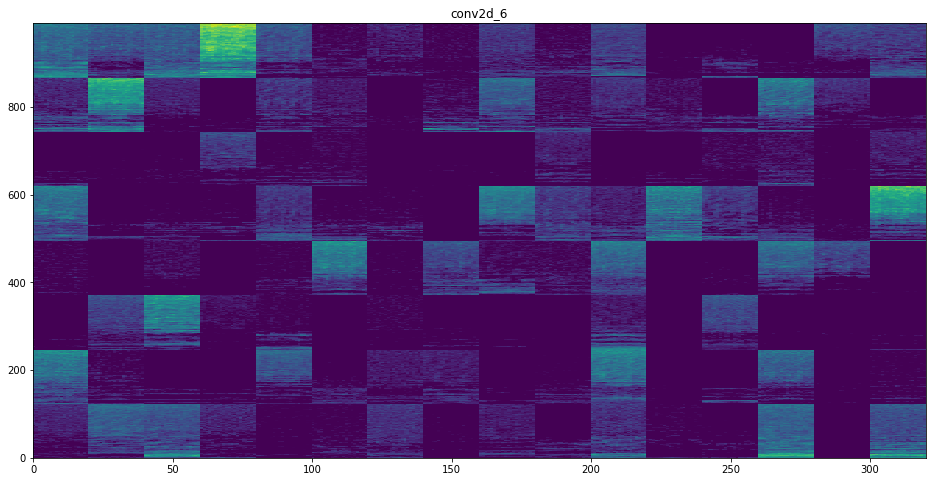

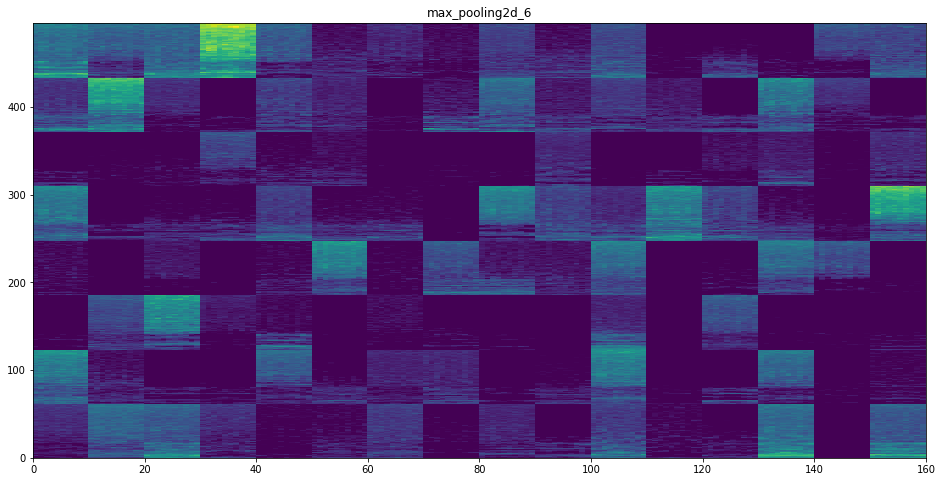

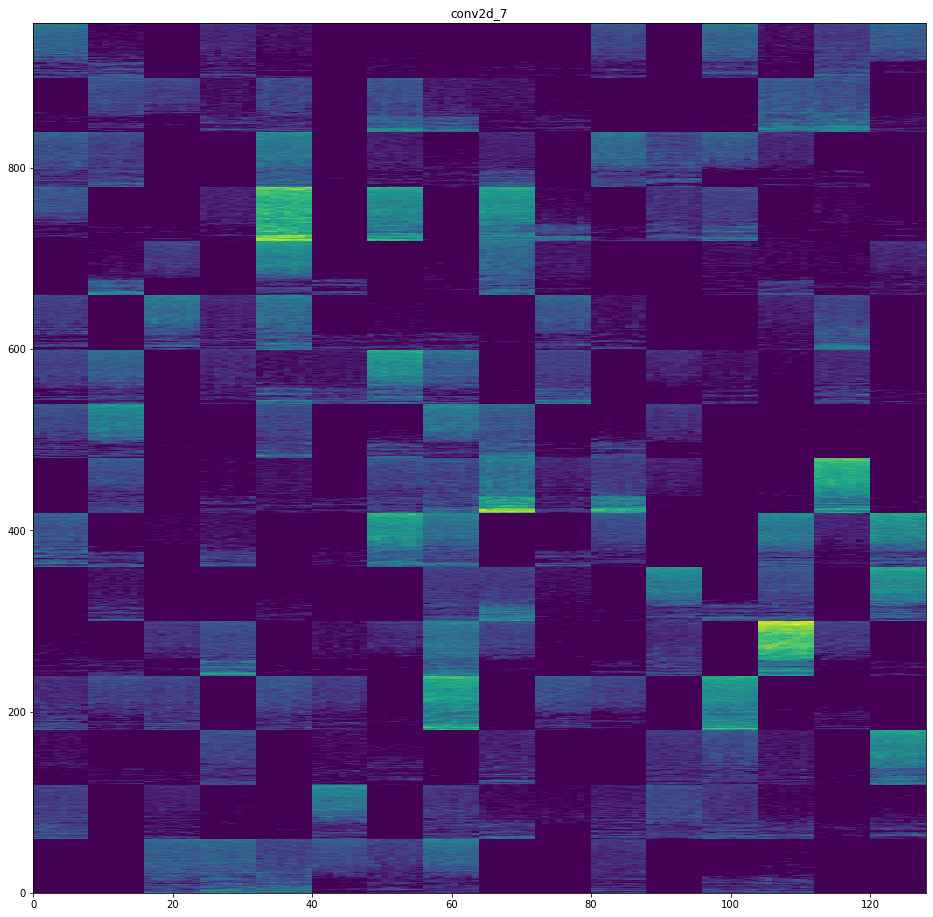

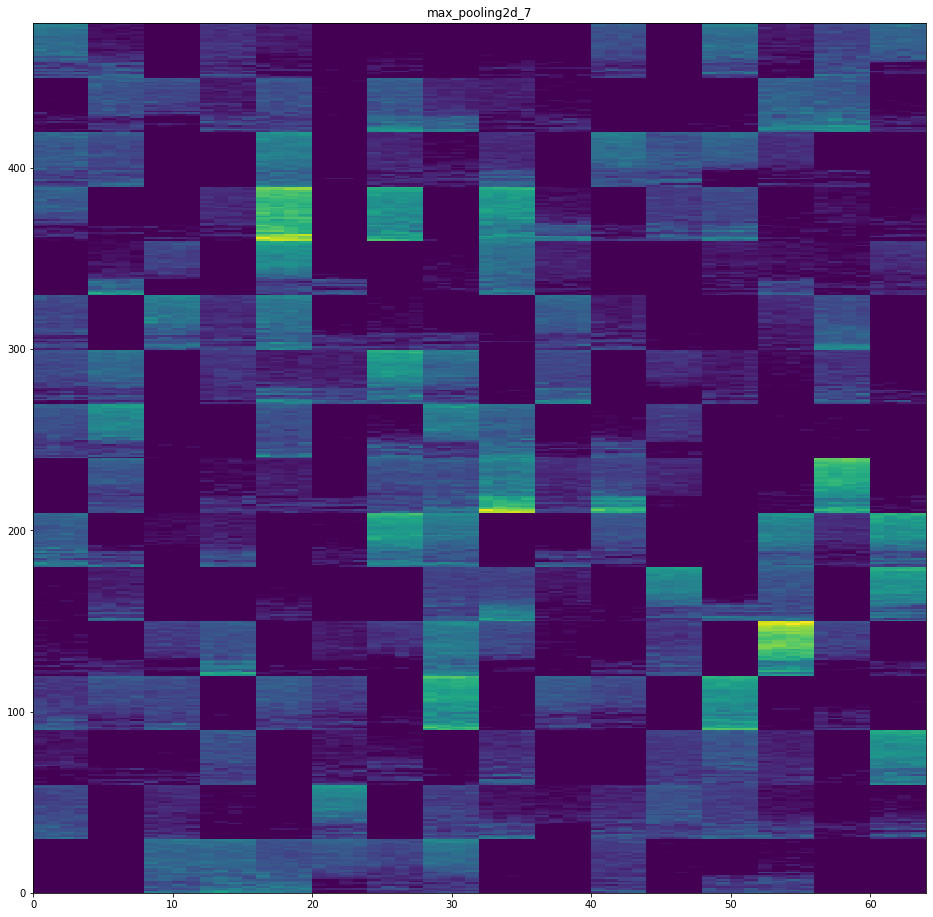

In [ ]:
from keras import models

model = deep_pitches.model
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.compat.v1.keras.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(prod_samples.xs[100].reshape((1, prod_samples.get_config().rows, prod_samples.get_config().cols)))

layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  n_cols = n_features // images_per_row
  print("%s:" % layer_name, n_features, layer_activation.shape)
  if len(layer_activation.shape) < 3:
    continue

  if n_cols == 0:
    continue

  col_size = layer_activation.shape[1]
  row_size = layer_activation.shape[2]

  display_grid = np.zeros((col_size * n_cols, images_per_row * row_size))

  for col in range(n_cols):
      for row in range(images_per_row):
          channel_image = layer_activation[0, :, :, col * images_per_row + row]
          # channel_image -= channel_image.mean()
          # channel_image /= channel_image.std()
          # channel_image *= 64
          # channel_image += 128
          # channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          display_grid[col * col_size : (col + 1) * col_size, row * row_size : (row + 1) * row_size] = channel_image
    
  col_scale =1. / col_size
  row_scale =1. / row_size

  plt.figure(figsize=(row_scale * display_grid.shape[1], col_scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.pcolormesh(display_grid, cmap='viridis')

# Save Models

In [ ]:
# Auth this runtime to GCP (once only)
from google.colab import auth
auth.authenticate_user()

In [ ]:
deepears.model.save("deepears_pitch_model.h5")

In [ ]:
!gsutil -m cp -a public-read *.h5 gs://muthanna.com/deepears

Copying file://deepears_root_model.h5 [Content-Type=application/octet-stream]...
Copying file://deepears_chord_model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 2 objects/331.0 MiB.                                    


# Live Test

In [ ]:
fs, data = wavfile.read('sweetchild-8bit.wav')
sample_len = int(8000 * 0.33) # 0.33ms slice of 8khz audio
num_samples = int(len(data) / sample_len)
remainder = len(data) % sample_len

samples = np.reshape(data[0:len(data) - remainder], (num_samples, sample_len))

In [ ]:
for i in range(0, num_samples):
  f, t, Sxx = signal.spectrogram(samples[i], fs, window=('hann'), nperseg=64, nfft=128, noverlap=16, mode='magnitude')
  Sxx = Sxx.reshape(1, 65, 54,1)
  root_class = deepears.root_model.predict_classes(Sxx)
  chord_class = deepears.chord_model.predict_classes(Sxx)
  
  chord = deepears.get_chord_classes()[int(chord_class)]
  root = deepears.get_root_classes()[int(root_class)]
  print(i * 0.33, "seconds:", root, chord)


0.0 seconds: Cs min7
0.33 seconds: Cs dom7
0.66 seconds: D dom7
0.99 seconds: As dom7
1.32 seconds: D dom7
1.6500000000000001 seconds: Fs dom7
1.98 seconds: Cs dom7
2.31 seconds: Fs min7
2.64 seconds: E maj7
2.97 seconds: D dom7
3.3000000000000003 seconds: F major
3.6300000000000003 seconds: D maj7
3.96 seconds: Cs min7
4.29 seconds: Fs sus2
4.62 seconds: Ds dom7
4.95 seconds: Ds dom7
5.28 seconds: Ds min7
5.61 seconds: Fs dom7
5.94 seconds: D dom7
6.2700000000000005 seconds: Cs dom7
6.6000000000000005 seconds: Cs dom7
6.930000000000001 seconds: D min7
7.260000000000001 seconds: Cs dom7
7.590000000000001 seconds: D dom7
7.92 seconds: Fs dom7
8.25 seconds: D dom7
8.58 seconds: G min7
8.91 seconds: Fs minor
9.24 seconds: D dom7
9.57 seconds: D dom7
9.9 seconds: B min7
10.23 seconds: Ds dom7
10.56 seconds: Fs dom7
10.89 seconds: Fs dom7
11.22 seconds: Cs dom7
11.55 seconds: C dom7
11.88 seconds: B maj7
12.21 seconds: Cs dom7
12.540000000000001 seconds: As dom7
12.870000000000001 seconds: 